10가지 사물의 이미지가 있는 CIFAR-10 데이터를 학습하고 그 종류를 판단하는 CNN 모델을 만들어봅시다. backend 의 image_data_format 을 channels_first 로 세팅하고 데이터셋을 읽어오면 shape 이 (batch, channels, height, width) 로 되어있는것을 알 수 있습니다.

channels_first
train_images <class 'numpy.ndarray'> (50000, 3, 32, 32) uint8
train_labels <class 'numpy.ndarray'> (50000, 1) uint8
test_images <class 'numpy.ndarray'> (10000, 3, 32, 32) uint8
test_labels <class 'numpy.ndarray'> (10000, 1) uint8


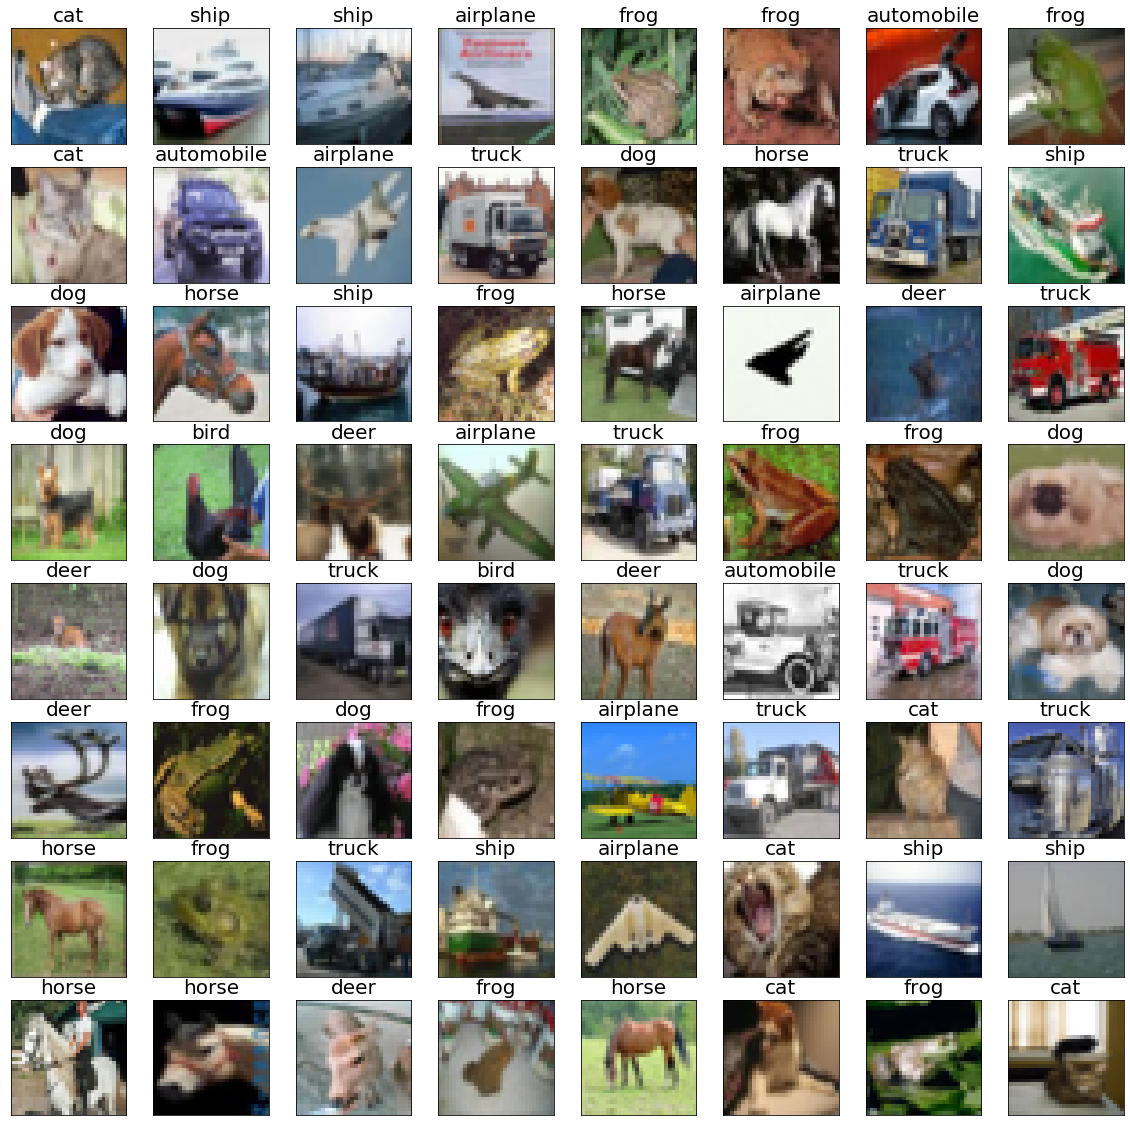

In [1]:
from tensorflow.keras import datasets, layers, models, utils
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

K.set_image_data_format( 'channels_first' )
print( K.image_data_format() )

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'train_labels', type(train_labels), train_labels.shape, train_labels.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )
print( 'test_labels', type(test_labels), test_labels.shape, test_labels.dtype )

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck' ]

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( class_names[test_labels[i][0]], {'fontsize':20} )
    plt.imshow( test_images[i].transpose(1, 2, 0) )

픽셀값을 0~1 로 정규화하고 double precision 까지는 필요가 없으므로 float32 로 변환합니다.

In [2]:
_, C, H, W = train_images.shape
train_x = ( train_images / 255 ).astype('float32')
test_x = ( test_images / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 3, 32, 32) float32


레이블을 열개의 카테고리를 가진 데이터로 바꾸어 줍니다.

In [3]:
num_classes = 10

print( 'test_labels', test_labels.shape, test_labels.dtype )
print( 'test_labels[0] =', test_labels[0] )

train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes)

print( 'test_y', test_y.shape, test_y.dtype )
print( 'test_y[0] =', test_y[0] )

test_labels (10000, 1) uint8
test_labels[0] = [3]
test_y (10000, 10) float32
test_y[0] = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Conv2D에서 입력 이미지의 가장자리에 패딩을 넣어 입력이미지와 같은 크기의 출력이미지를 유지시켜주는 padding='same' 옵션을 사용했습니다. channels_first 로 셋팅을 했으므로 모델 summary 를 보면 Conv2D 출력의 shape 이 (Batch, depth, height, width) 임을 알 수 있습니다.

In [4]:
x = layers.Input( (C, H, W) )
h = layers.Conv2D( 128, (3, 3), padding='same', activation='relu' )(x)
h = layers.MaxPooling2D( (2, 2) )(h)
h = layers.Conv2D( 256, (3, 3), padding='same', activation='relu' )(h)
h = layers.MaxPooling2D( (2, 2) )(h)
h = layers.Conv2D( 256, (3, 3), padding='same', activation='relu' )(h)
h = layers.MaxPooling2D( (2, 2) )(h)
h = layers.Flatten()(h)
h = layers.Dropout( 0.5 )(h)
h = layers.Dense( 256, activation='relu' )(h)
h = layers.Dropout( 0.5 )(h)
y = layers.Dense(num_classes, activation='softmax')(h)

model = models.Model(x, y)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 32, 32)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 32, 32)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 16, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 16, 16)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 8, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 8, 8)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 4, 4)         0     

softmax를 거친 category 출력에 주로 사용하는 categorical_crossentropy loss 함수를 사용합니다. 학습의 중간 결과로 정확성도 출력하기 위하여 accuracy 라는 측정 항목을 지정해 줍니다.

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 18s 403us/sample - loss: 1.6644 - accuracy: 0.3851 - val_loss: 1.2700 - val_accuracy: 0.5378
Epoch 2/30
45000/45000 [==============================] - 16s 348us/sample - loss: 1.2550 - accuracy: 0.5482 - val_loss: 1.0110 - val_accuracy: 0.6588
Epoch 3/30
45000/45000 [==============================] - 16s 349us/sample - loss: 1.0569 - accuracy: 0.6251 - val_loss: 0.8650 - val_accuracy: 0.6966
Epoch 4/30
45000/45000 [==============================] - 16s 349us/sample - loss: 0.9327 - accuracy: 0.6717 - val_loss: 0.7905 - val_accuracy: 0.7312
Epoch 5/30
45000/45000 [==============================] - 16s 349us/sample - loss: 0.8507 - accuracy: 0.7006 - val_loss: 0.7580 - val_accuracy: 0.7380
Epoch 6/30
45000/45000 [==============================] - 16s 349us/sample - loss: 0.7848 - accuracy: 0.7241 - val_loss: 0.7034 - val_accuracy: 0.7668
Epoch 7/30
45000/45000 [=====================

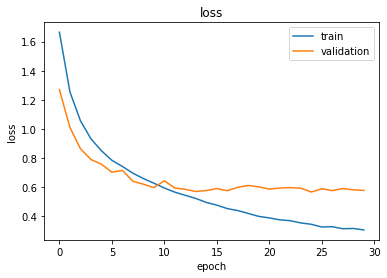

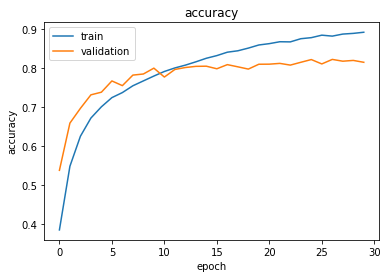

10000/10000 [==============================] - 2s 178us/sample - loss: 0.6183 - accuracy: 0.8020
[loss, accuracy] = [0.6182972578048707, 0.802]


In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.1)

from modules.plot_history import plot_history
plot_history(hist, 'loss')
plot_history(hist, 'accuracy')

evaluation = model.evaluate( test_x, test_y, batch_size=64)
print( '[loss, accuracy] =', evaluation )

검증데이터로 모델에 입력을 넣어 어떠한 출력이 나오는지 확인해봅시다.

y_pred (10000, 10) float32
y_pred[0] [9.7306242e-04 9.0321363e-04 6.8076170e-04 6.3305980e-01 9.1722535e-07
 3.6304644e-01 4.1397192e-04 8.4536492e-05 3.4836819e-04 4.8900727e-04]
class_pred (10000,) int64
class_pred[0] 3


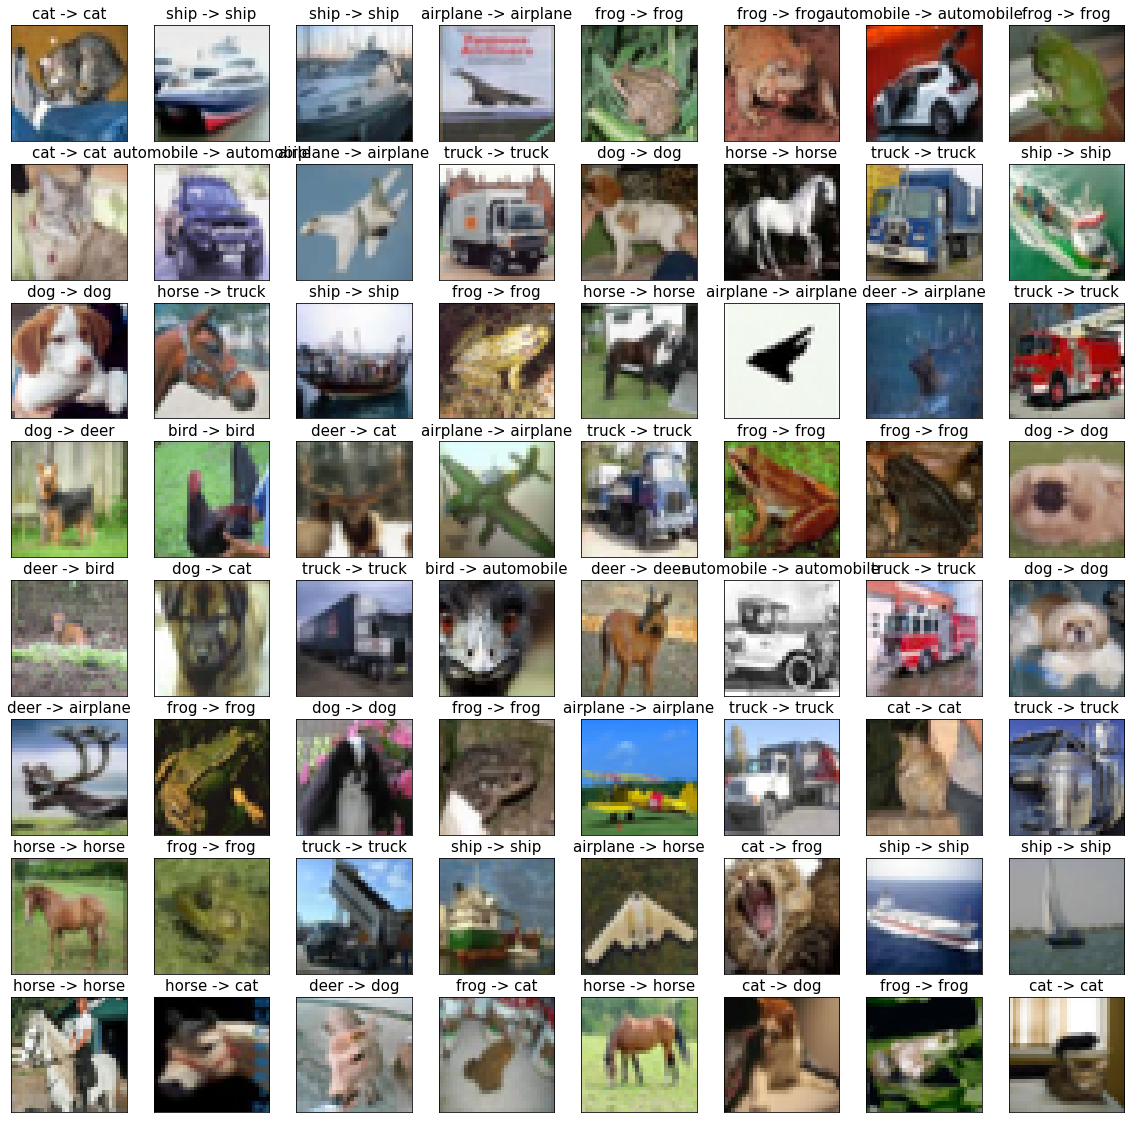

In [6]:
y_pred = model.predict(test_x)
print('y_pred', y_pred.shape, y_pred.dtype)
print('y_pred[0]', y_pred[0])

#class_pred = model.predict_classes( test_x ) # only for sequential model
class_pred = np.argmax(y_pred, axis=1)
print('class_pred', class_pred.shape, class_pred.dtype)
print('class_pred[0]', class_pred[0])

plt.figure( figsize=(20,20) )
for i in range(0,8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title(class_names[test_labels[i][0]] + ' -> '  +
              class_names[class_pred[i]], {'fontsize':15} )
    plt.imshow( test_images[i].transpose(1,2,0) )

학습한 모델의 웨이트들을 저장합니다.

In [7]:
model.save('cifar10_model_channels_first.h5')